In [1]:
import pandas as pd

data = pd.read_csv("out/small.edgedata.csv", sep=";")[["edge_id", "edge_entered", "edge_speed"]].rename(columns={
    "edge_entered": "flow",
    "edge_speed": "vehicle_speed"})
#data["flow"] = data["flow"].apply(lambda x : x / 24)
data.head()

,edge_id,flow,vehicle_speed
0,1,4742,28.66
1,10,51,28.31
2,100,1173,28.40
3,1000,2222,27.65
4,1001,173,28.36


In [2]:
len(data.index)

1116

In [3]:
covered_edges = data["edge_id"].unique()

for i in range(1220):
    if i not in covered_edges:
        data.loc[len(data.index)] = [i, 0, 0.0]
        
data["edge_id"].nunique()

1220

In [4]:
edgelist = pd.read_csv("out/small.edges.csv", sep=";")
edgelist.head()

,edge_from,edge_id,edge_length,edge_numLanes,edge_speed,edge_to
0,1614922744,0,23.141939,2,29.0576,1614922747
1,269459339,1,60.826398,5,29.0576,269459341
2,1621320618,2,109.464966,2,29.0576,1621320622
3,269459229,3,160.720645,3,29.0576,269459230
4,607954833,4,173.017706,3,29.0576,1613371666


In [5]:
edgelist = pd.merge(edgelist, data, on="edge_id")

ordered_cols = ["edge_id", "edge_from", "edge_to", "edge_length", "edge_numLanes", "edge_speed", "flow", "vehicle_speed"]
edgelist = edgelist[ordered_cols]

edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,4742.0,28.66
2,2,1621320618,1621320622,109.464966,2,29.0576,0.0,0.00
3,3,269459229,269459230,160.720645,3,29.0576,2546.0,28.28
4,4,607954833,1613371666,173.017706,3,29.0576,2296.0,2.65


In [6]:
edgelist["flow"].nunique()

551

In [7]:
(edgelist["flow"] == 0).sum()

129

In [24]:
edgelist["flow"].median()

810.5

In [28]:
(edgelist["vehicle_speed"] < 1).sum()

104

In [8]:
edgelist.to_csv("out/small.results.csv", index=False)

In [9]:
nodes = pd.read_csv("out/small.nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


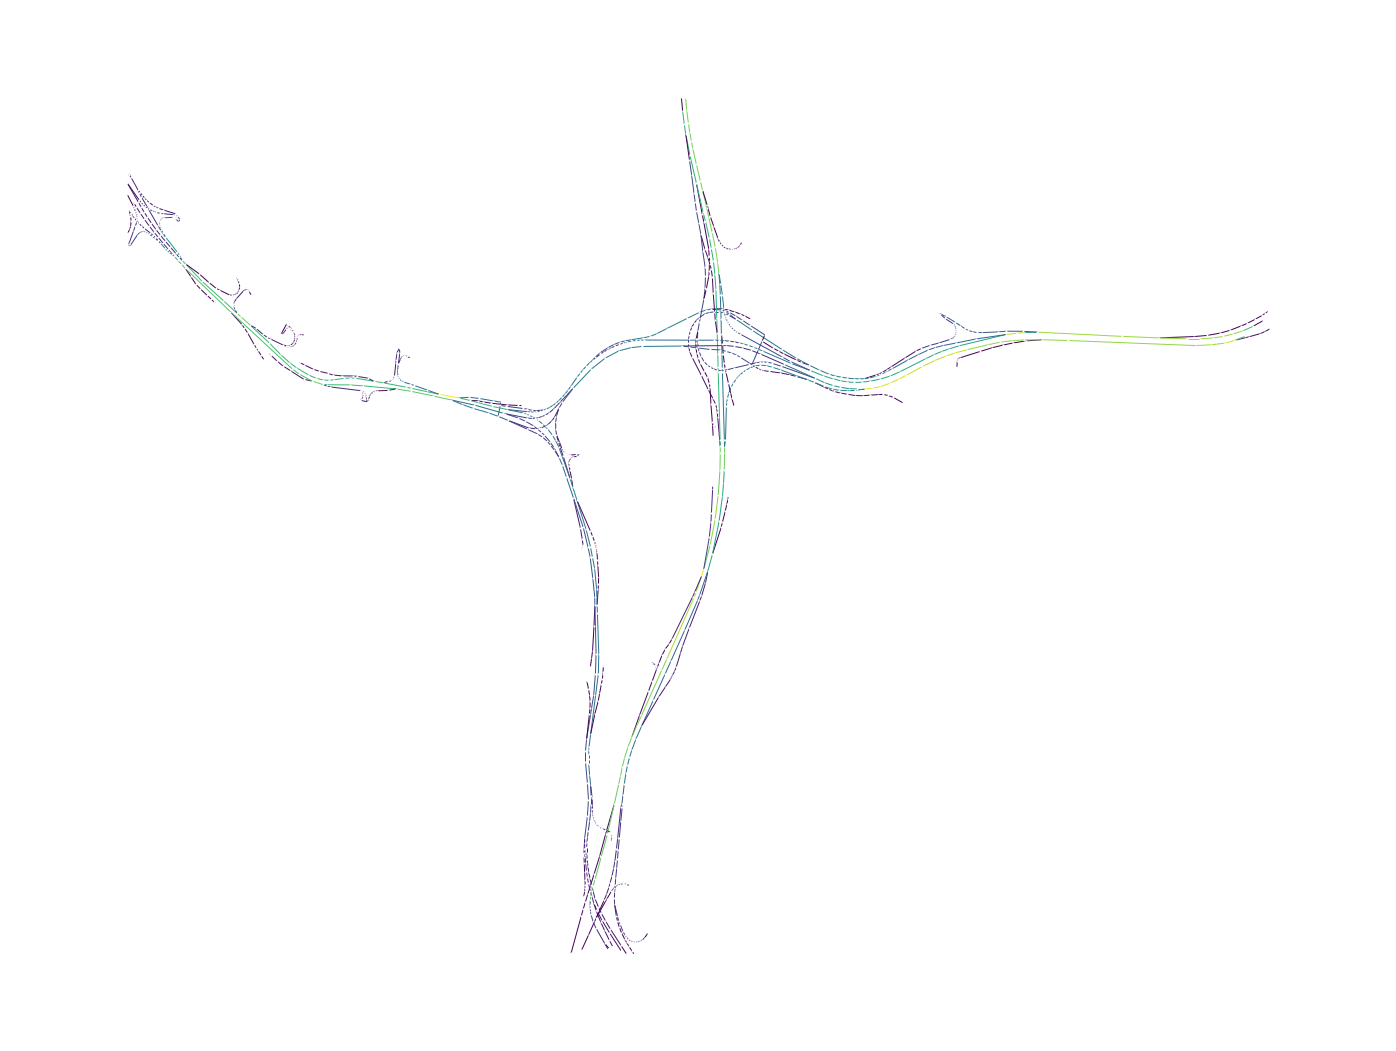

In [10]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
cmap = mpl.colormaps["viridis"]

G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"])
nx.set_node_attributes(G, nodes.to_dict("index"))

edge_colors = [(G[u][v]["flow"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

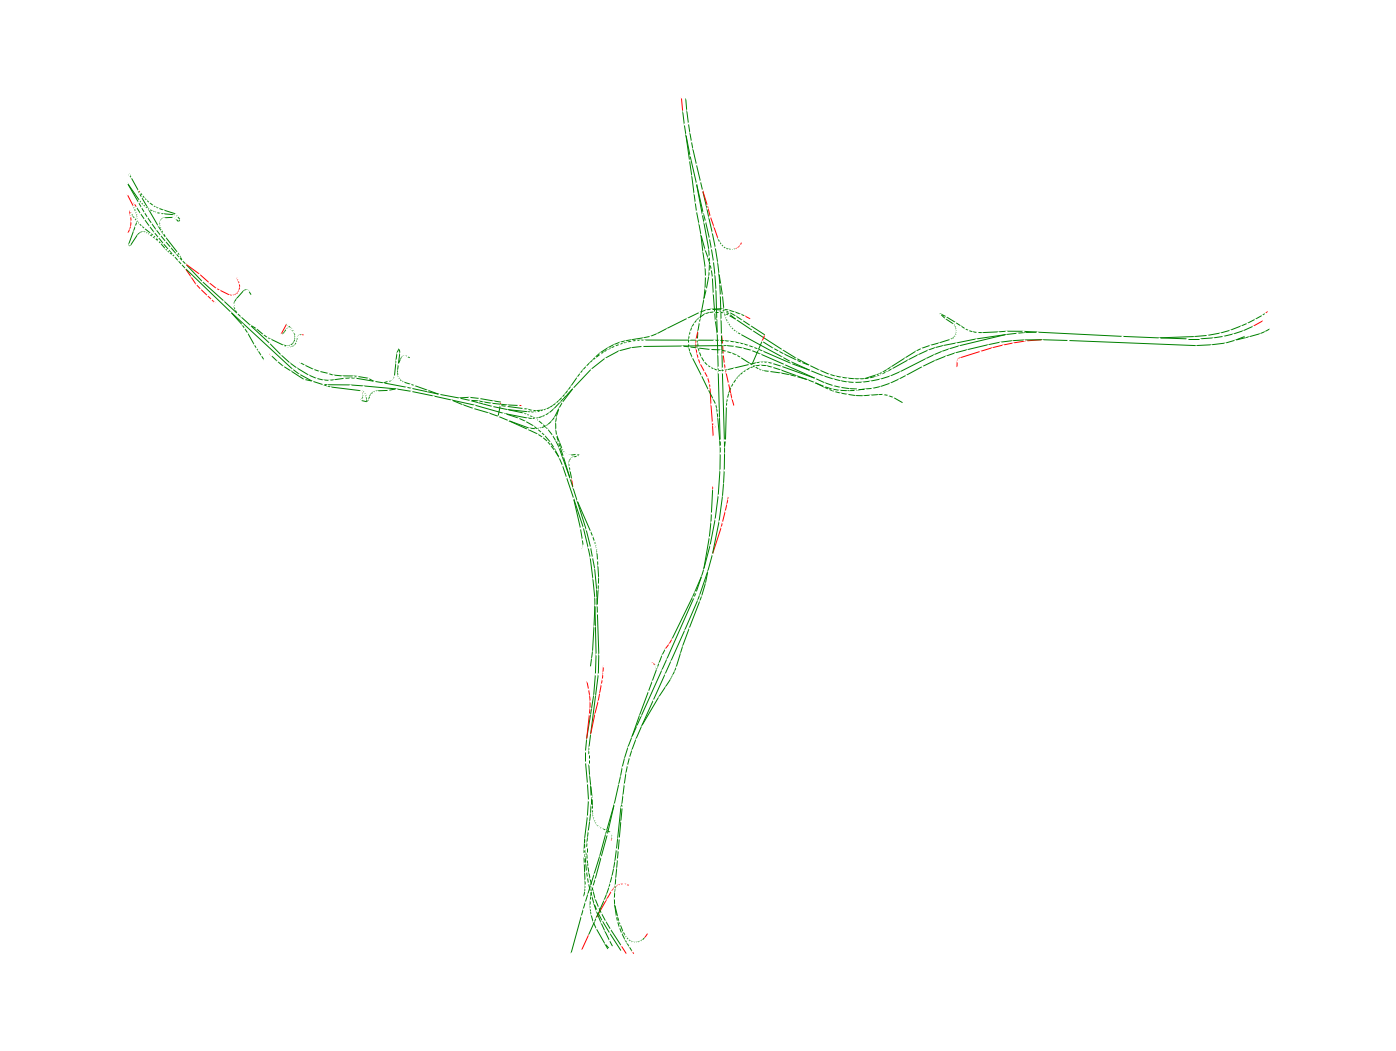

In [11]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = ["red" if G[u][v]["flow"] == 0 else "green" for u,v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

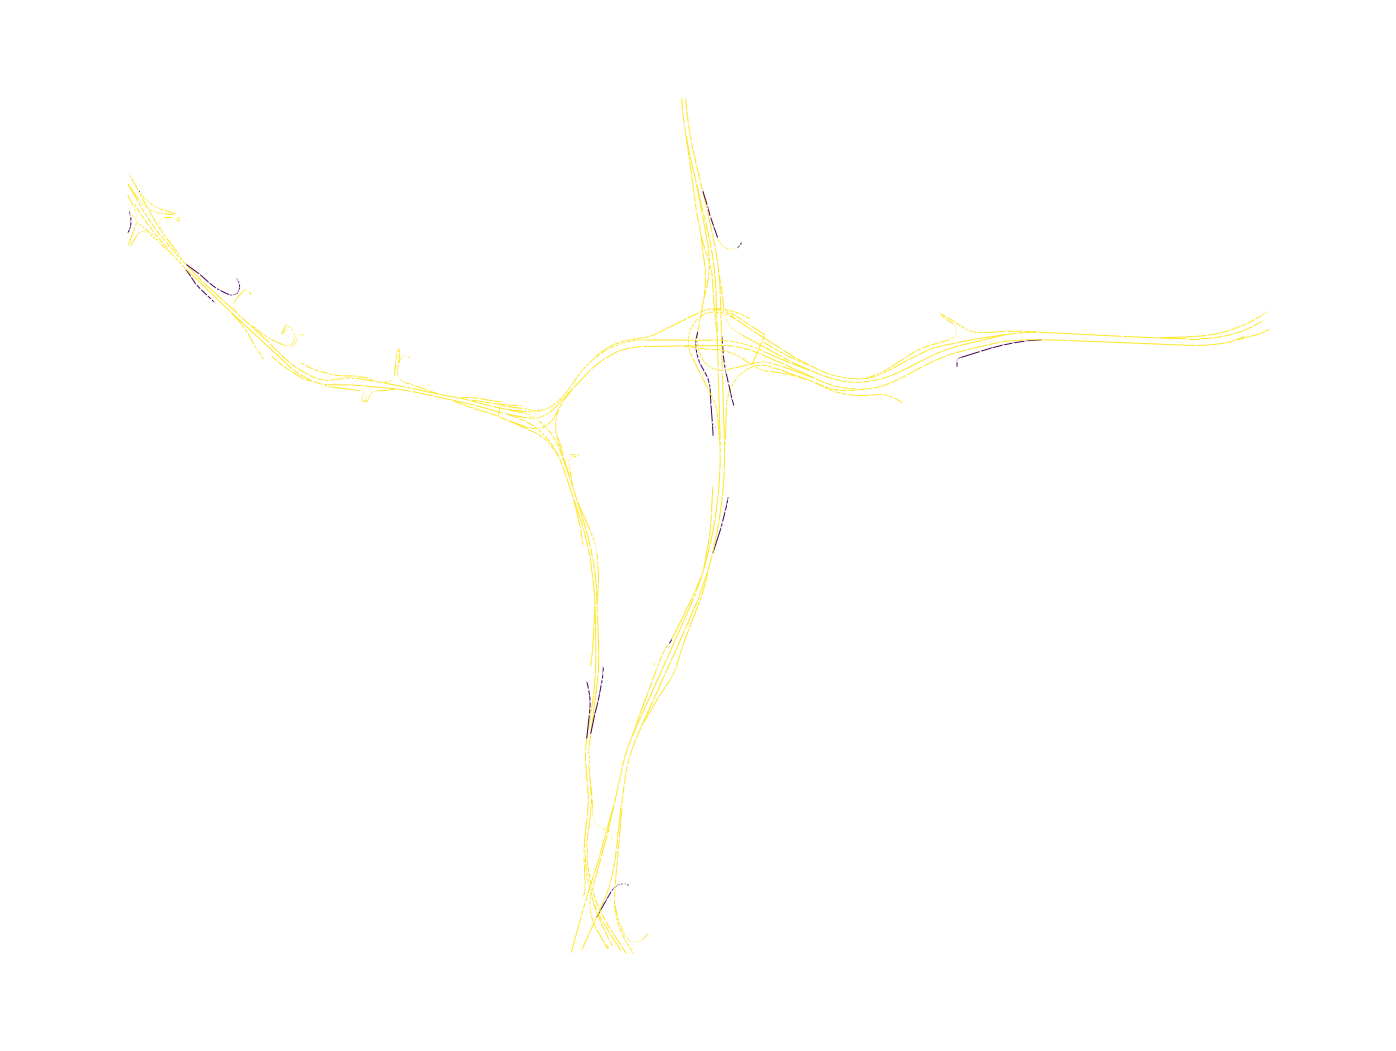

In [12]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
edge_colors = [cmap(G[u][v]["vehicle_speed"]) for u, v in G.edges]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.show()

In [13]:
import pickle 
import numpy as np

with open('data/small_speeds.pkl', 'rb') as f:
    speeds = pickle.load(f)

with open('data/small_flows.pkl', 'rb') as f:
    flows = pickle.load(f)

In [21]:
detectors = []

sat = 0
for k, c in flows.items():
    u, v = [int(i) for i in k]
    m = G[u][v]["flow"]
    geh = np.sqrt(2 * (m - c) ** 2 / (m + c))
    sat += (geh < 5)
    detectors.append(G[u][v]["edge_id"])
    print(G[u][v]["edge_id"], m, c, geh)
    
print("GEH<5 for", 100 * sat / len(detectors), "%")

28 514.0 513.3680555555555 0.027882445958089686
82 3967.0 3997.3967803030305 0.4816883451711789
106 349.0 374.99138332557055 1.3660849080814832
132 3527.0 3526.808197282795 0.003229668368261692
167 4941.0 4940.214408037447 0.011176526903328854
168 5468.0 5469.434981162233 0.0194045446314819
214 3912.0 3929.2595238095237 0.27564549130032945
224 2382.0 2363.6783879438294 0.37612268650079556
232 188.0 190.07737801872844 0.15109155244390998
236 5053.0 5618.16120561708 7.7371586189730595
247 189.0 190.82601530311948 0.1325034105870685
283 2546.0 2912.1792442059595 7.0094642485291185
317 4919.0 5128.9810480648475 2.962481815846659
353 312.0 312.1148539465506 0.006501725969058203
369 4347.0 4384.524717433497 0.5679202895428164
414 3170.0 3167.9422308482704 0.0365542192200629
446 145.0 830.7866586538462 31.047496865573358
463 704.0 1981.5700422422651 34.86434218895108
473 4742.0 4744.8544354378355 0.04144518703588346
503 3999.0 4070.063363397648 1.1187915910746227
525 2655.0 2652.696426532709 

In [30]:
err = 0
high_err_detectors = []

for k, s in speeds.items():
    u, v = [int(i) for i in k]
    m = G[u][v]["vehicle_speed"]
    err += (s * 0.44704 - G[u][v]["vehicle_speed"]) ** 2
    if abs(s * 0.44704 - G[u][v]["vehicle_speed"]) > 5:
        high_err_detectors.append(G[u][v]["edge_id"])
        print(G[u][v]["edge_id"], s * 0.44704, G[u][v]["vehicle_speed"])
    

print("Speed MSE:", err / len(speeds))

82 25.418745200000004 7.81
214 24.317113333333335 2.95
369 25.690014352323324 9.15
473 21.418192184495943 28.62
503 25.347877425276856 6.26
638 21.9767658 3.42
766 30.00822476721087 4.18
911 23.035012827956987 2.04
926 20.48484370909921 2.81
1084 29.597896249343535 9.59
Speed MSE: 122.15356647327873


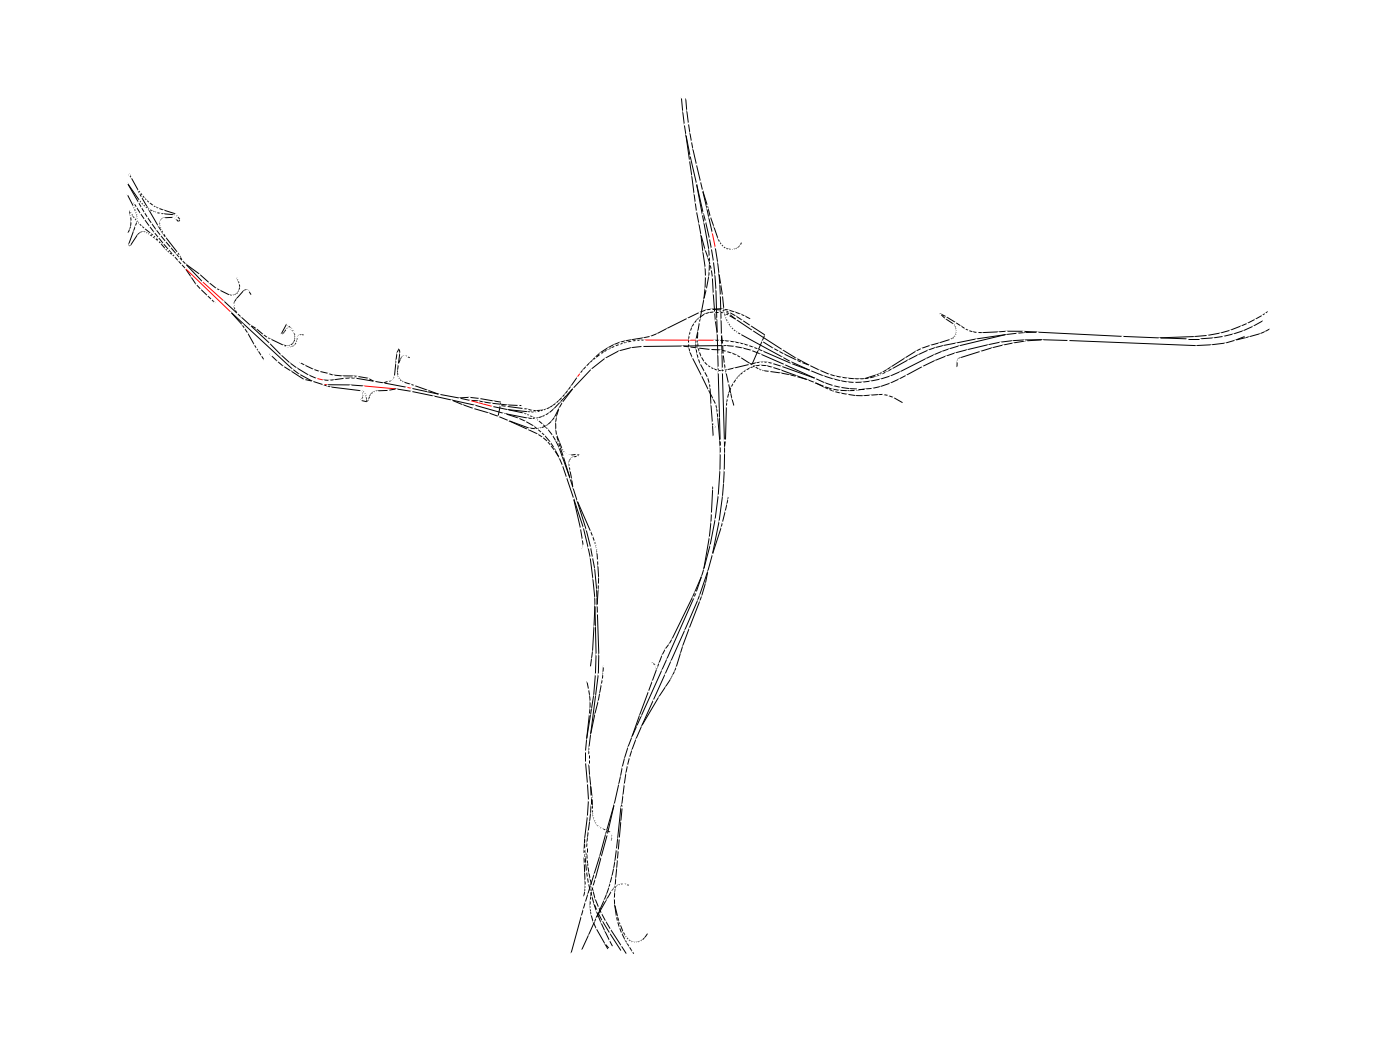

In [31]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in high_err_detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

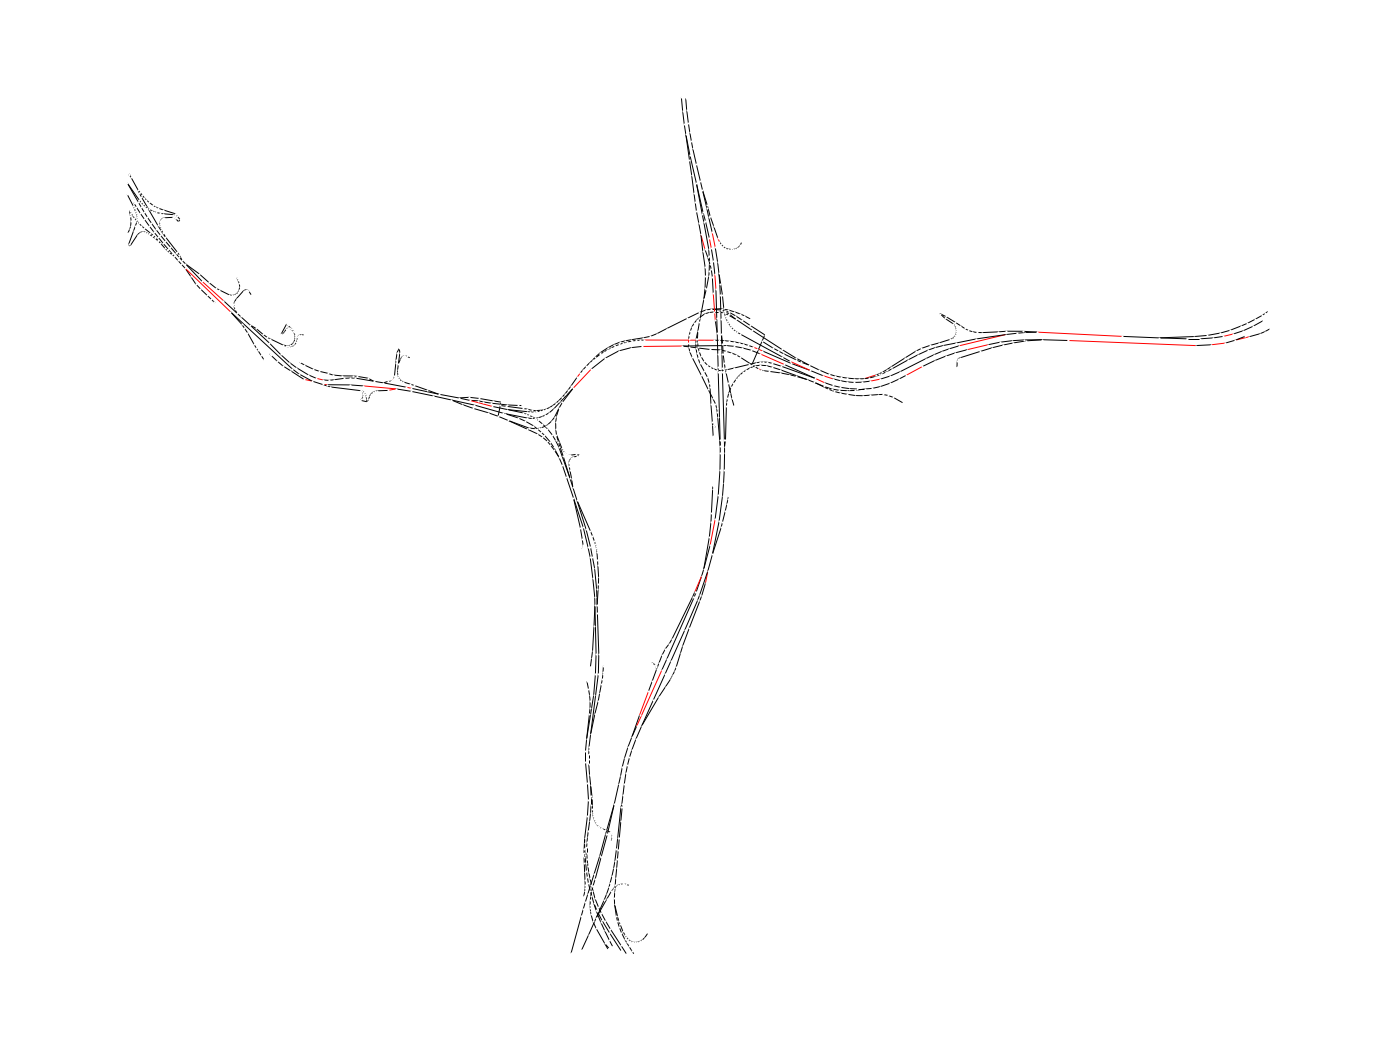

In [16]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])

edge_colors = ["red" if G[u][v]["edge_id"] in detectors else "black" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

(array([511., 199., 147., 133.,  54.,  34.,  48.,  40.,  31.,  15.]),
 array([   0. ,  589.8, 1179.6, 1769.4, 2359.2, 2949. , 3538.8, 4128.6,
        4718.4, 5308.2, 5898. ]),
 <BarContainer object of 10 artists>)

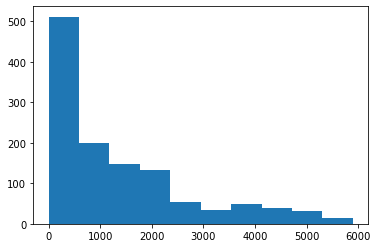

In [17]:
plt.hist([G[u][v]["flow"] for u,v in G.edges])

(array([12.,  1.,  1.,  3.,  3.,  2.,  6.,  5.,  7.,  3.]),
 array([ 153.79798995,  700.23431152, 1246.67063308, 1793.10695465,
        2339.54327622, 2885.97959778, 3432.41591935, 3978.85224092,
        4525.28856248, 5071.72488405, 5618.16120562]),
 <BarContainer object of 10 artists>)

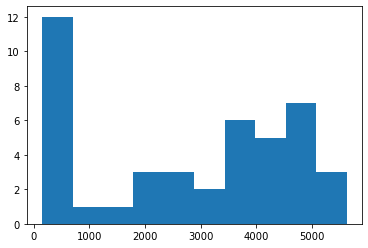

In [18]:
plt.hist(flows.values())

(array([169.,  72.,  35.,  22.,  14.,  13.,  15.,   7.,  31., 842.]),
 array([ 0.   ,  2.966,  5.932,  8.898, 11.864, 14.83 , 17.796, 20.762,
        23.728, 26.694, 29.66 ]),
 <BarContainer object of 10 artists>)

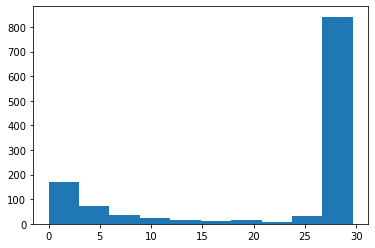

In [19]:
plt.hist(data["vehicle_speed"])

(array([2., 1., 1., 0., 1., 5., 2., 6., 6., 6.]),
 array([20.48484371, 21.43718181, 22.38951992, 23.34185803, 24.29419613,
        25.24653424, 26.19887234, 27.15121045, 28.10354856, 29.05588666,
        30.00822477]),
 <BarContainer object of 10 artists>)

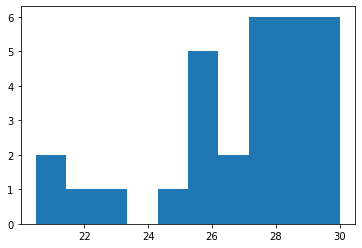

In [20]:
plt.hist([v * 0.44704 for v in speeds.values()])